# Baseline Model

## Data Window, Batch, Epoch & Shuffling
### Data Window
- **Data windowing** is a process in which we define a sequence of data points on our time series and define which are inputs and which are labels.
    - This is an important concept for modeling time series in deep learning
- For example, a single window has a total length of 48 timesteps which consists of 24 timesteps as inputs and 24 as outputs (labels).
<p align="center"><img src="../../assets/img/data-window-examples.png" width=600><br>Different data windows that are generated by repeatedly shifting the starting point by one timestep in the training set</p>

- Different data windows that are generated by repeatedly shifting the starting point by one timestep in the training set. 
    - The first data window starts at $t = 0$. 
    - The second data window starts  at $t = 1$. This goes on until it cannot have a sequence of 24 consecutive labels in the training set
### Batch
- **Batch** is the collection of data windows that are used for training the deep learning model.
- Example of a batch with a batch size of 32. That means that 32 data windows are grouped together and used to train the model.
### Epoch
- For example, the training set has 12,285 data windows. 
    - If each batch has 32 data windows, that means that we will have 12285/32 = 384 batches.
    - Training the model on all 384 batches once is called one **epoch**. 
- One epoch often does not result in an accurate model, so the model will train for as many epochs as necessary until it cannot improve the accuracy of its predictions.
### Shuffling
- Time series data has an order, and that order must be kept, so why are we shuffling the data here ?
- In this context, shuffling occurs at the batch level, NOT inside the data window (i.e. the order of the time series itself is maintained within each data window).
- Shuffling the data is not essential, but it is recommended as it tends to make more robust models.

<p align="center"><img src="../../assets/img/shuffling.png" width=600><br>Shuffling the data windows in a batch.</p>

### `DataWindow` Class Implementation
- **The width of the input**: the number of timesteps that are fed into the model to make predictions. 
- **The width of the label**: the number of timesteps in the predictions. 
    - If we predict only one timestep, the label width is 1. If we predict a full day of data (with hourly data), the label width is 24.
- **The shift**: shift is the number of timesteps separating the input and the predictions. 
    - If we predict the next timestep, the shift is 1. 
    - If we predict the next 24 hours (with hourly data), the shift is 24.

<p align="center"><img src="../../assets/img/data-window-shift-examples.png" width=600><br>There are 24 timesteps separating the inputs and the predictions, the shift is also 24.</p>

- $\text{Total window size} = \text{input width} + \text{shift}$

In [1]:
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf

from tensorflow.keras import Model
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

import warnings
warnings.filterwarnings('ignore')

In [2]:
print(tf.__version__)
tf.random.set_seed(42)
np.random.seed(42)

2.16.1


In [3]:
df = pd.read_csv("../../data/book-time-series-forecasting-in-python/metro_interstate_traffic_volume_preprocessed.csv", parse_dates=[0])

In [4]:
cols_to_drop = ['rain_1h', 'snow_1h']
df = df.drop(cols_to_drop, axis=1)

In [5]:
# feature engineering
timestamp_s = pd.to_datetime(df['date_time']).map(datetime.datetime.timestamp)
day = 24 * 60 * 60                     
 
df['day_sin'] = (np.sin(timestamp_s * (2*np.pi/day))).values
df['day_cos'] = (np.cos(timestamp_s * (2*np.pi/day))).values   
df = df.drop(['date_time'], axis=1)

In [6]:
# train-test split
n = len(df)
 
# Split 70:20:10 (train:validation:test)
train_df = df[0:int(n*0.7)]               
val_df = df[int(n*0.7):int(n*0.9)]        
test_df = df[int(n*0.9):] 

In [7]:
scaler = MinMaxScaler()
scaler.fit(train_df)       
 
train_df.loc[:, train_df.columns] = scaler.transform(train_df[train_df.columns])
val_df.loc[:,val_df.columns] = scaler.transform(val_df[val_df.columns])
test_df.loc[:,test_df.columns] = scaler.transform(test_df[test_df.columns])

In [8]:
print(train_df.shape, val_df.shape, test_df.shape)

(12285, 5) (3510, 5) (1756, 5)


In [9]:
input_slice = slice(24, None)
print(input_slice)
input_indices = np.arange(48)[input_slice]
print(input_indices)

slice(24, None, None)
[24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]


In [10]:
class DataWindow():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df, val_df=val_df, test_df=test_df, 
                 label_columns=None):
        
        self.train_df = train_df # contains both X & y
        self.val_df = val_df
        self.test_df = test_df
        
        self.label_columns = label_columns # name of target (label) column to predict
        if label_columns is not None:
            # Create a dictionary with the name and index of the label column. 
            # This will be used for plotting
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        # Create a dictionary with the name and index of each column. 
        # This will be used to separate the features from the target variable.
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        # Define: input width, label width, and shift of the data window
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        # Define total window size of the data window
        self.total_window_size = input_width + shift
        
        # The slice function returns a slice object that specifies how to slice a sequence. 
        # In this case, it says that the input slice starts at "0" and ends when we reach the "input_width".
        self.input_slice = slice(0, input_width)
        # input_indices = [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        # Get the index at which the label starts. 
        # In this case, it is the total window size minus the width of the label.
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        # label_indices = [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def split_to_inputs_labels(self, features):
        """This is to split the data window into input and label arrays, so that our models can make predictions based on the inputs and measure an error metric against the labels.

        Args:
            features (_type_): _description_

        Returns:
            inputs (_type_): _description_
            labels (_type_):
        """
        # Slice the window to get the inputs using the "input_slice" defined in __init__.
        inputs = features[:, self.input_slice, :]
        # Slice the window to get the labels using the "labels_slice" defined in __init__.
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            # If we have more than one target, we stack the labels.
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        # The shape will be [batch, time, features]. 
        # At this point, we only specify the "time" dimension and allow the "batch" and "feature" dimensions to be defined later.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
        
    def make_dataset(self, data, batch_size=32):
        """format the dataset into tensors so that they can be fed to our deep learning models

        Args:
            data (pd.Dataframe): training set, validation set, or test set.
            batch_size (int, optional): batch size. Defaults to 32.

        Returns:
            _type_: _description_
        """
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None, # targets=None, as they are handled by the "split_to_input_labels" function.
            sequence_length=self.total_window_size, # the total window length.
            sequence_stride=1, # the number of timesteps separating each sequence.
            shuffle=True,
            batch_size=batch_size # Define the number of sequences in a single batch.
        )
        # This is used to apply the split_to_inputs_labels method to each element of the dataset ds. 
        # This method processes each time series window (a sequence of data points) to extract the input features and corresponding labels
        ds = ds.map(self.split_to_inputs_labels)
        return ds
    
    @property
    def train(self):
        # to apply the "make_dataset" function on the training dataset
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def sample_batch(self):
        # create a sample batch that we’ll cache within the class for plotting purposes.

        # checks if there is already a cached sample batch stored in the instance attribute "_sample_batch". 
        # If "_sample_batch" exists, it is assigned to result. 
        # If not, result is set to None
        result = getattr(self, '_sample_batch', None)
        if result is None:
            # If the sample batch does not exist, we’ll retrieve a sample batch and cache it.
            result = next(iter(self.train))
            self._sample_batch = result
        return result
        
    def plot(self, model=None, plot_col='traffic_volume', max_subplots=3):
        """plot the input data, the predictions, and the actual values

        Args:
            model (_type_, optional): _description_. Defaults to None.
            plot_col (str, optional): _description_. Defaults to 'traffic_volume'.
            max_subplots (int, optional): _description_. Defaults to 3.
        """
        inputs, labels = self.sample_batch
        
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col] # identify the index of the plot_col
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            # Plot the inputs. They will appear as a continuous blue line with dots.
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue
            # Plot the labels or actual values. They will appear as green squares.
            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
                predictions = model(inputs)
                # Plot the predictions. They will appear as red crosses.
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)
            if n == 0:
                plt.legend()

        plt.xlabel('Time (h)')

## Baseline Model
- A baseline is used as a benchmark to evaluate more complex models. A model is performant if it compares favorably to another, so building a baseline is an important step in modeling.

### Single-step baseline model
-  A single-step model: the input width is 1, the label width is 1, and the shift is also 1
- For example, the model is to predict the traffic volume for the next time step
    - In this case, the model naive baseline model is to use the last observed value to predict for the next time step

In [11]:
single_step_window = DataWindow(input_width=1, label_width=1, shift=1, label_columns=['traffic_volume']) 

In [12]:
class Baseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        if self.label_index is None:
            # if no target is specified, we return all columns. 
            return inputs
        
        elif isinstance(self.label_index, list):
            # if we specify a list of targets, it will return only the specified columns.
            tensors = []
            for index in self.label_index:
                result = inputs[:, :, index]
                result = result[:, :, tf.newaxis]
                tensors.append(result)
            return tf.concat(tensors, axis=-1)
        
        # return the input as the prediction
        result = inputs[:, :, self.label_index]
        return result[:,:,tf.newaxis]

In [13]:
column_indices = {name: i for i, name in enumerate(train_df.columns)}
baseline_last = Baseline(label_index=column_indices['traffic_volume'])
baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

In [14]:
val_performance = {}
performance = {}
# this model is not required .fit() 
val_performance['Baseline - Last'] = baseline_last.evaluate(single_step_window.val)
performance['Baseline - Last'] = baseline_last.evaluate(single_step_window.test, verbose=0)

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 656us/step - loss: 0.0130 - mean_absolute_error: 0.0818


In [15]:
# this returns an MAE of 0.081. 
print(performance['Baseline - Last'][1])

0.08128398656845093


### Multi-step baseline models
- There are 2 reasonable baselines:
    - Model 1: Predict the last known value for the next 24 timesteps.
    - Model 2: Predict the last 24 timesteps for the next 24 timesteps.



In [16]:
multi_window = DataWindow(input_width=24, label_width=24, shift=24, label_columns=['traffic_volume'])

#### Predicting the last known value

In [17]:
# Predicting the last known value
class MultiStepLastBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        if self.label_index is None:
            # If no target is specified, return the last known value of all columns over the next 24 timesteps.
            return tf.tile(inputs[:, -1:, :], [1, 24, 1]) 
        # Return the last known value of the target column over the next 24 timesteps              
        return tf.tile(inputs[:, -1:, self.label_index:], [1, 24, 1])   

In [18]:
ms_baseline_last = MultiStepLastBaseline(label_index=column_indices['traffic_volume'])
ms_baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

ms_val_performance = {}
ms_performance = {}

ms_val_performance['Baseline - Last'] = ms_baseline_last.evaluate(multi_window.val)
ms_performance['Baseline - Last'] = ms_baseline_last.evaluate(multi_window.test, verbose=0)

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 649us/step - loss: 0.1866 - mean_absolute_error: 0.3514


In [19]:
print(ms_performance['Baseline - Last'][1]) # [0] is loss, [1] is MAE

0.3469807207584381


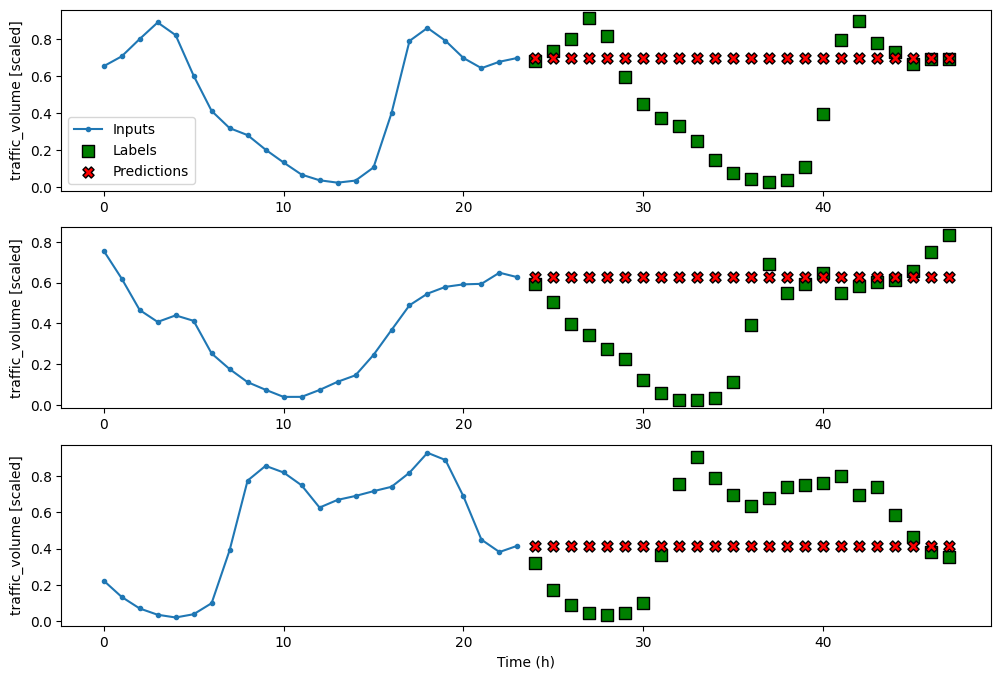

In [25]:
multi_window.plot(model=ms_baseline_last)

#### Repeating the input sequence
- This means that the prediction for the next 24 hours will simply be the last known 24 hours of data

In [21]:
class RepeatBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        return inputs[:, :, self.label_index:]

In [22]:
ms_baseline_repeat = RepeatBaseline(label_index=column_indices['traffic_volume'])

ms_baseline_repeat.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

ms_val_performance['Baseline - Repeat'] = ms_baseline_repeat.evaluate(multi_window.val)
ms_performance['Baseline - Repeat'] = ms_baseline_repeat.evaluate(multi_window.test, verbose=0)

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 658us/step - loss: 0.0822 - mean_absolute_error: 0.2023


In [23]:
print(ms_performance['Baseline - Repeat'][1])

0.19551168382167816


- The MAE of the repeating input sequence yield a better result (MAE=0.195) then the last known model (MAE=0.346)

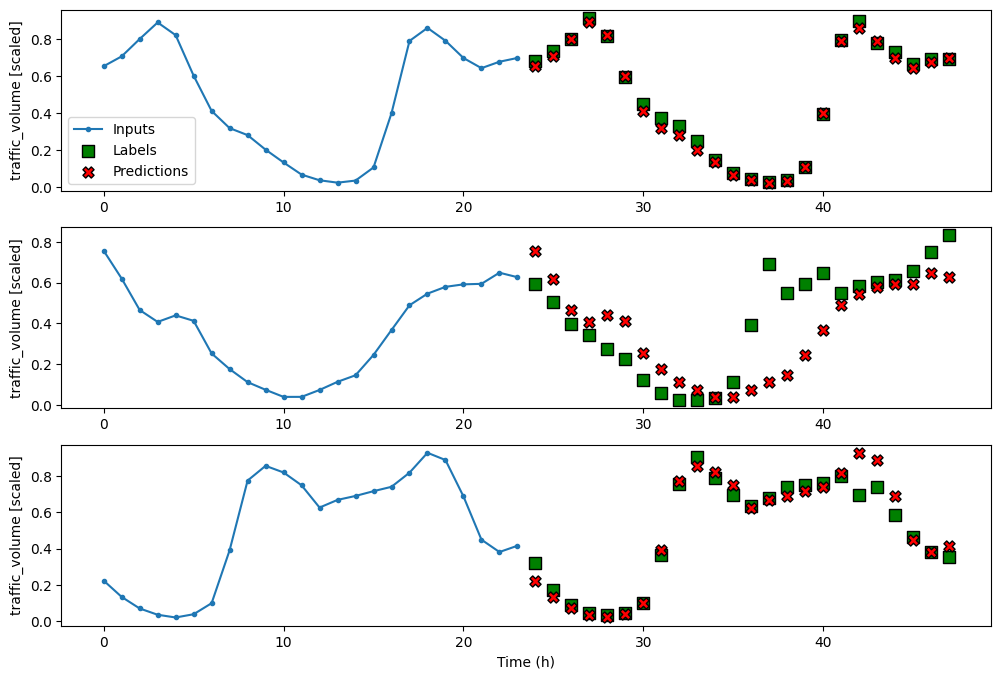

In [26]:
multi_window.plot(model=ms_baseline_repeat)

### Multi-output baseline model
- In this example, the model is to predict the traffic volume and the temperature for the next timestep using a single input data point.

In [27]:
mo_single_step_window = DataWindow(input_width=1, label_width=1, shift=1, label_columns=['temp','traffic_volume']) 
mo_wide_window = DataWindow(input_width=24, label_width=24, shift=1, label_columns=['temp','traffic_volume'])

print(column_indices['traffic_volume'])
print(column_indices['temp'])

2
0


In [28]:
mo_baseline_last = Baseline(label_index=[column_indices['temp'], column_indices['traffic_volume']])
mo_baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

mo_val_performance = {}
mo_performance = {}

mo_val_performance['Baseline - Last'] = mo_baseline_last.evaluate(mo_wide_window.val)
mo_performance['Baseline - Last'] = mo_baseline_last.evaluate(mo_wide_window.test, verbose=0)

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step - loss: 0.0069 - mean_absolute_error: 0.0483


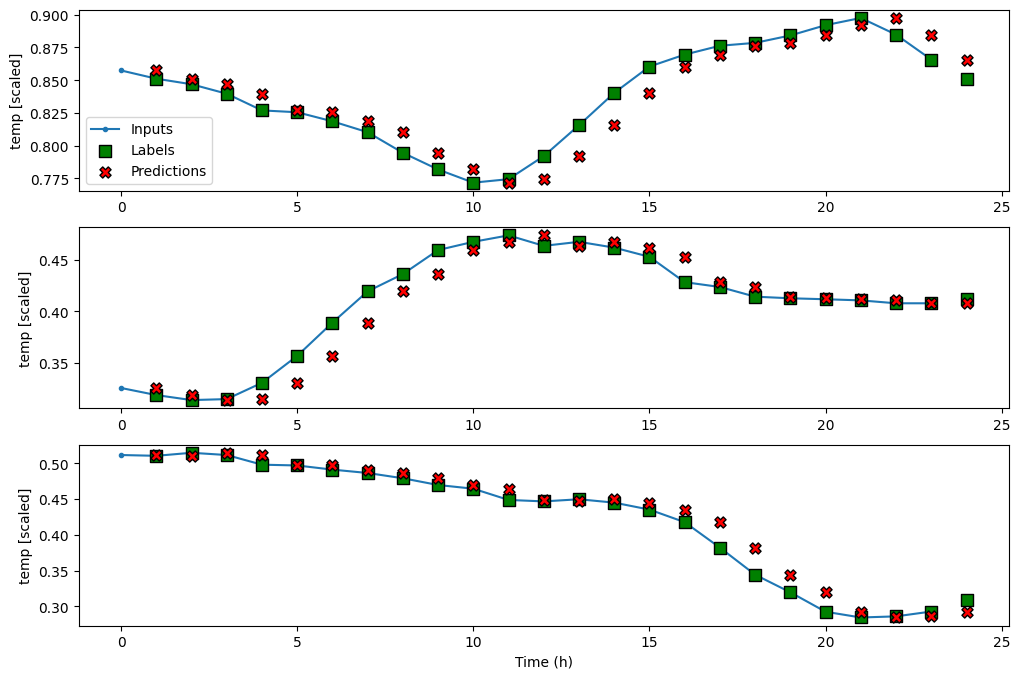

In [29]:
mo_wide_window.plot(model=mo_baseline_last, plot_col='temp')

In [31]:
print(mo_performance['Baseline - Last'][1])

0.047106675803661346
